# Credits predicting - MSHP competition 2023 S211

# Install libraries

In [2]:
!pip install catboost
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 145.7 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 215.8 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 434.0 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 596.8 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 585.7 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.7/613.7 kB 414.3 kB/s eta 0:00:00a 0:00:01


# Import libraries

In [3]:
# Data
import pandas as pd
import numpy as np

## Drawing
%matplotlib inline
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

## Train, test split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from catboost import Pool, metrics, cv
from xgboost import DMatrix

## Impute data
from sklearn.impute import SimpleImputer

## Normalize data
from sklearn.preprocessing import MinMaxScaler

# ML
## Models
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight

## Params selection
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
import optuna

ignore warnings

In [4]:
import warnings
warnings.filterwarnings("ignore")

# Data preprocess

In [6]:
df_train = pd.read_csv('./datasets/credit_train.csv')
df_test = pd.read_csv('./datasets/credit_test.csv')

In [7]:
df_test

,id,gender,age,marital_status,credit_sum,credit_month,tariff_id,education,credit_count,overdue_credit_count,job_pos,credit_score,region,income
0,39162,F,18,UNM,"39469,00",6,1.44,GRD,NaN,NaN,SPC,"0,424628",САНКТ-ПЕТЕРБУРГ Г,30000.0
1,10673,F,63,WID,"16693,00",10,1.32,GRD,2.0,0.0,SPC,"0,311945",ОБЛ ЛЕНИНГРАДСКАЯ,21250.0
2,121409,M,42,MAR,"60260,00",10,1.10,GRD,5.0,0.0,SPC,"0,421982",МОСКВА Г,150000.0
3,23504,M,41,MAR,"32479,00",12,1.10,GRD,1.0,0.0,DIR,"0,406572",ТАТАРСТАН РЕСП,150000.0
4,69269,F,24,UNM,"8159,00",12,1.10,SCH,2.0,0.0,SPC,"0,418243",ТВЕРСКАЯ ОБЛ,16000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56342,14148,F,21,UNM,"40980,00",24,1.90,GRD,1.0,0.0,SPC,"0,429402",САМАРСКАЯ,22000.0
56343,153732,M,56,MAR,"16009,00",10,1.10,SCH,0.0,0.0,SPC,"0,494229",САМАРСКАЯ ОБЛ,29000.0
56344,37647,M,54,MAR,"22448,00",12,1.10,SCH,1.0,0.0,UMN,"0,312089",РОСТОВСКАЯ ОБЛ,26500.0
56345,92808,F,27,UNM,"13829,00",10,1.90,GRD,2.0,0.0,SPC,"0,339009",ОБЛ СВЕРДЛОВСКАЯ,38000.0


In [8]:
df_train

,id,gender,age,marital_status,credit_sum,credit_month,tariff_id,education,credit_count,overdue_credit_count,job_pos,credit_score,region,income,opened
0,26031,M,24,UNM,"24000,00",10,1.60,SCH,2.0,0.0,SPC,"0,728851",ОБЛ ЛЕНИНГРАДСКАЯ,35000.0,True
1,148877,M,23,UNM,"16339,00",18,1.10,SCH,2.0,0.0,SPC,"0,347385",МОСКВА Г,38000.0,True
2,142019,M,54,UNM,"15652,00",10,1.32,GRD,2.0,0.0,SPC,"0,349705",ОБЛ МОСКОВСКАЯ,38000.0,True
3,146816,F,52,UNM,"16560,00",10,1.10,SCH,1.0,0.0,SPC,"0,359232",РЕСП МОРДОВИЯ,28000.0,False
4,27699,F,63,WID,"9078,00",18,1.10,SCH,4.0,0.0,SPC,"0,529368",ЧЕЛЯБИНСКАЯ ОБЛ,30000.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114394,119880,M,29,MAR,"29678,00",10,1.60,GRD,1.0,0.0,SPC,"0,721156",ОМСКАЯ ОБЛАСТЬ,25000.0,False
114395,103695,M,29,MAR,"23068,00",15,1.10,GRD,3.0,0.0,SPC,"0,566393",ТЮМЕНСКАЯ ОБЛ,30000.0,True
114396,131933,F,45,MAR,"16418,00",10,1.10,SCH,1.0,0.0,UMN,"0,327380",ОБЛ БРЯНСКАЯ,30400.0,False
114397,146868,F,49,MAR,"12169,00",10,1.40,SCH,1.0,0.0,SPC,"0,467395",ТАМБОВСКАЯ ОБЛ,16000.0,False


array([[<Axes: title={'center': 'id'}>, <Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'credit_month'}>],
       [<Axes: title={'center': 'tariff_id'}>,
        <Axes: title={'center': 'credit_count'}>,
        <Axes: title={'center': 'overdue_credit_count'}>],
       [<Axes: title={'center': 'income'}>, <Axes: >, <Axes: >]],
      dtype=object)

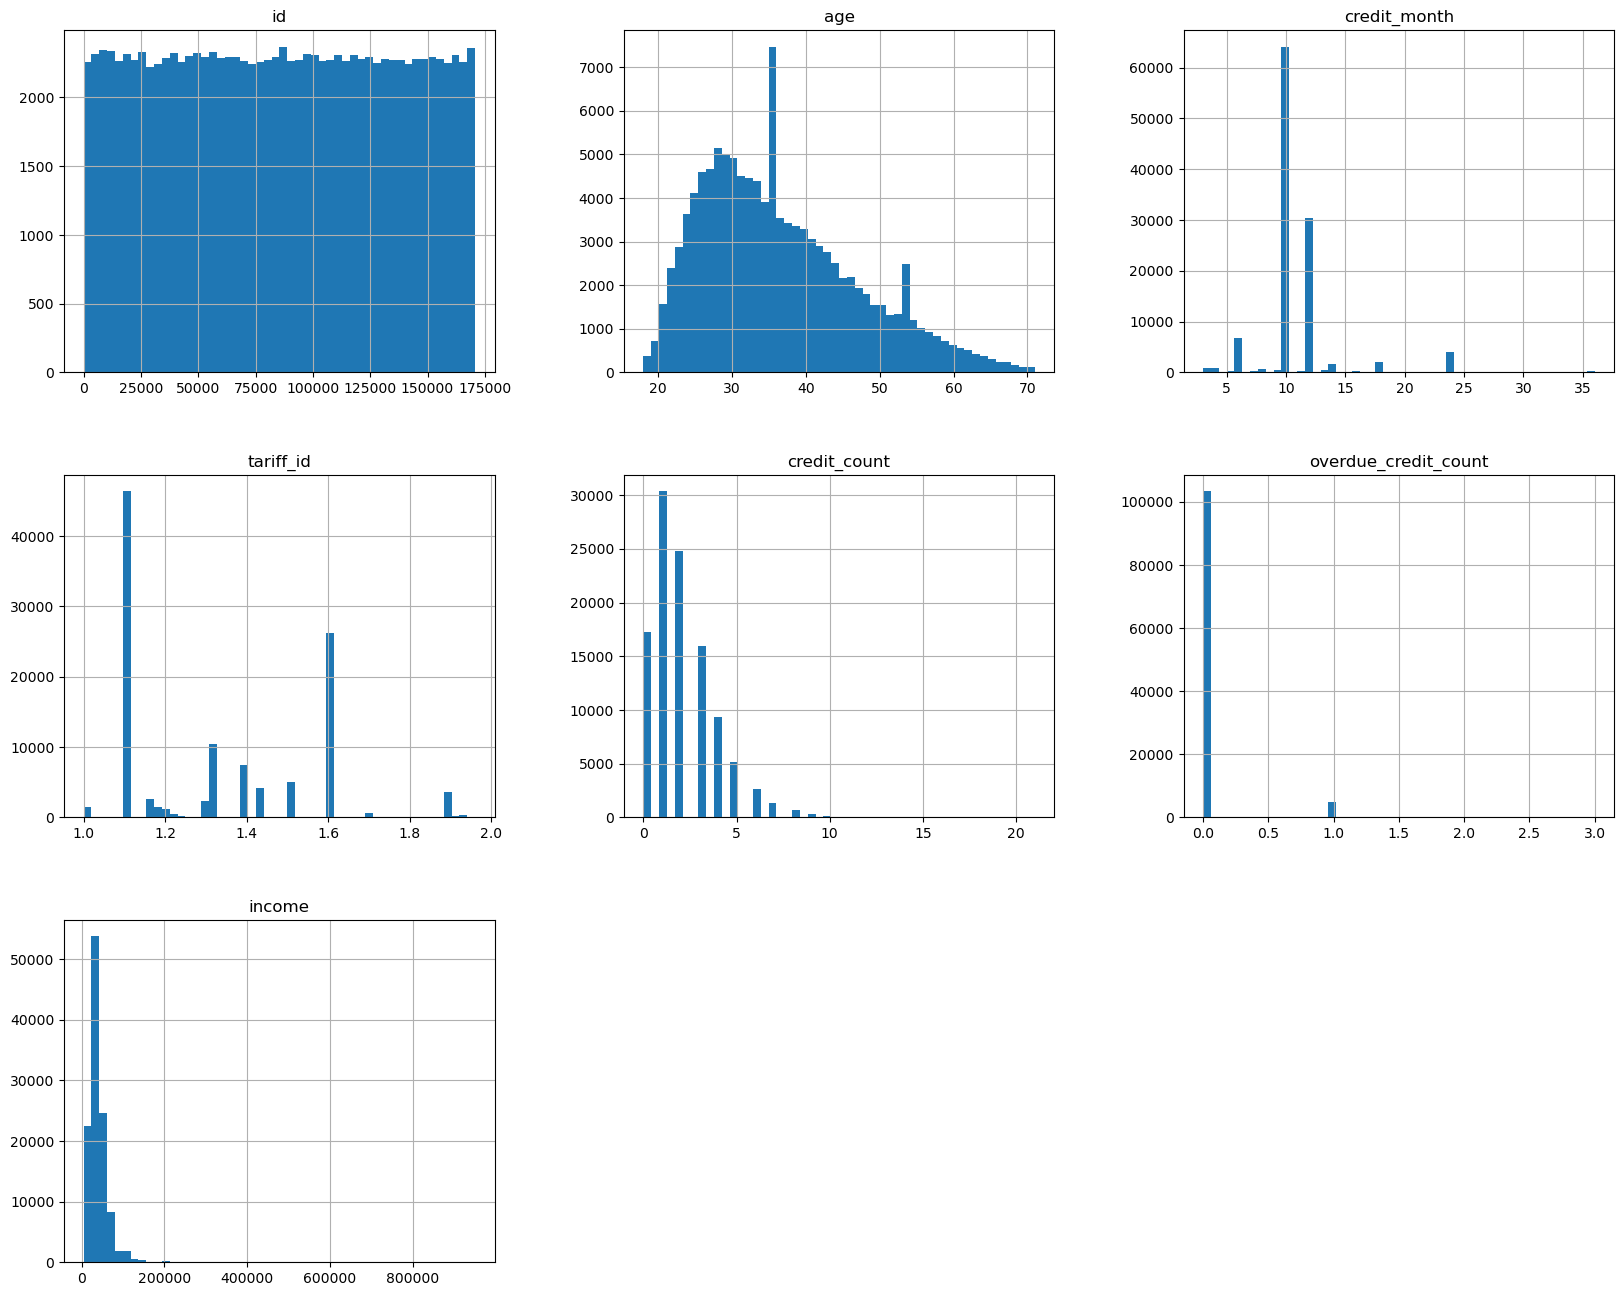

In [9]:
df_train.hist(bins=50, figsize=(20, 16))

Видим что некоторые "числа" записаны через запятую - не круто. Удалим id никакого смысла не несет :/
НО!!! tariff_id не выкидываем это номер тарифа поэтому может сослужит службу

Стратификацию делать стоит, потому что кроме credit_score все признаки распределены не ровно, поэтому стоит хоть как то выровнять выборку

In [10]:
df_train.drop(columns = ['id'], axis=1, inplace=True)
# df_test.drop(columns = ['id'], axis=1, inplace=True)
# df_train.drop(columns = ['tariff_id'], axis=1, inplace=True)
# df_test.drop(columns = ['tariff_id'], axis=1, inplace=True)

In [11]:
df_train

,gender,age,marital_status,credit_sum,credit_month,tariff_id,education,credit_count,overdue_credit_count,job_pos,credit_score,region,income,opened
0,M,24,UNM,"24000,00",10,1.60,SCH,2.0,0.0,SPC,"0,728851",ОБЛ ЛЕНИНГРАДСКАЯ,35000.0,True
1,M,23,UNM,"16339,00",18,1.10,SCH,2.0,0.0,SPC,"0,347385",МОСКВА Г,38000.0,True
2,M,54,UNM,"15652,00",10,1.32,GRD,2.0,0.0,SPC,"0,349705",ОБЛ МОСКОВСКАЯ,38000.0,True
3,F,52,UNM,"16560,00",10,1.10,SCH,1.0,0.0,SPC,"0,359232",РЕСП МОРДОВИЯ,28000.0,False
4,F,63,WID,"9078,00",18,1.10,SCH,4.0,0.0,SPC,"0,529368",ЧЕЛЯБИНСКАЯ ОБЛ,30000.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114394,M,29,MAR,"29678,00",10,1.60,GRD,1.0,0.0,SPC,"0,721156",ОМСКАЯ ОБЛАСТЬ,25000.0,False
114395,M,29,MAR,"23068,00",15,1.10,GRD,3.0,0.0,SPC,"0,566393",ТЮМЕНСКАЯ ОБЛ,30000.0,True
114396,F,45,MAR,"16418,00",10,1.10,SCH,1.0,0.0,UMN,"0,327380",ОБЛ БРЯНСКАЯ,30400.0,False
114397,F,49,MAR,"12169,00",10,1.40,SCH,1.0,0.0,SPC,"0,467395",ТАМБОВСКАЯ ОБЛ,16000.0,False


In [12]:
df_train['credit_sum'] = df_train['credit_sum'].map(lambda x: x.replace(',', '.'))
df_train['credit_score'] = df_train['credit_score'].map(lambda x: x.replace(',', '.'))

df_train['credit_sum'] = df_train['credit_sum'].astype(dtype=np.float64)
df_train['credit_score'] = df_train['credit_score'].astype(dtype=np.float64)

df_train['opened'] = df_train['opened'].astype(dtype=np.int64)

In [13]:
df_test['credit_sum'] = df_test['credit_sum'].map(lambda x: x.replace(',', '.'))
df_test['credit_score'] = df_test['credit_score'].map(lambda x: x.replace(',', '.'))

df_test['credit_sum'] = df_test['credit_sum'].astype(dtype=np.float64)
df_test['credit_score'] = df_test['credit_score'].astype(dtype=np.float64)

In [14]:
df_test

,id,gender,age,marital_status,credit_sum,credit_month,tariff_id,education,credit_count,overdue_credit_count,job_pos,credit_score,region,income
0,39162,F,18,UNM,39469.0,6,1.44,GRD,NaN,NaN,SPC,0.424628,САНКТ-ПЕТЕРБУРГ Г,30000.0
1,10673,F,63,WID,16693.0,10,1.32,GRD,2.0,0.0,SPC,0.311945,ОБЛ ЛЕНИНГРАДСКАЯ,21250.0
2,121409,M,42,MAR,60260.0,10,1.10,GRD,5.0,0.0,SPC,0.421982,МОСКВА Г,150000.0
3,23504,M,41,MAR,32479.0,12,1.10,GRD,1.0,0.0,DIR,0.406572,ТАТАРСТАН РЕСП,150000.0
4,69269,F,24,UNM,8159.0,12,1.10,SCH,2.0,0.0,SPC,0.418243,ТВЕРСКАЯ ОБЛ,16000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56342,14148,F,21,UNM,40980.0,24,1.90,GRD,1.0,0.0,SPC,0.429402,САМАРСКАЯ,22000.0
56343,153732,M,56,MAR,16009.0,10,1.10,SCH,0.0,0.0,SPC,0.494229,САМАРСКАЯ ОБЛ,29000.0
56344,37647,M,54,MAR,22448.0,12,1.10,SCH,1.0,0.0,UMN,0.312089,РОСТОВСКАЯ ОБЛ,26500.0
56345,92808,F,27,UNM,13829.0,10,1.90,GRD,2.0,0.0,SPC,0.339009,ОБЛ СВЕРДЛОВСКАЯ,38000.0


## Выделим категориальные и числовые признаки

In [15]:
categorical_train = df_train.select_dtypes(include=[object]).astype(str)
number_train = df_train.select_dtypes(include=[int, float, bool])

In [16]:
categorical_train = pd.concat([categorical_train, number_train['tariff_id']], axis=1)
number_train.drop(columns=['tariff_id'], inplace=True)

In [17]:
categorical_train['tariff_id'] = categorical_train['tariff_id'].map(lambda x: str(x))

In [18]:
categorical_test = df_test.select_dtypes(include=[object]).astype(str)
number_test = df_test.select_dtypes(include=[int, float, bool])

In [19]:
categorical_test = pd.concat([categorical_test, number_test['tariff_id']], axis=1)
number_test.drop(columns=['tariff_id'], inplace=True)

In [20]:
categorical_train['tariff_id'] = categorical_train['tariff_id'].map(lambda x: str(x))
categorical_test['tariff_id'] = categorical_test['tariff_id'].map(lambda x: str(x))

In [21]:
categorical_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114399 entries, 0 to 114398
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   gender          114399 non-null  object
 1   marital_status  114399 non-null  object
 2   education       114399 non-null  object
 3   job_pos         114399 non-null  object
 4   region          114399 non-null  object
 5   tariff_id       114399 non-null  object
dtypes: object(6)
memory usage: 5.2+ MB


In [22]:
number_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114399 entries, 0 to 114398
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   age                   114399 non-null  int64  
 1   credit_sum            114399 non-null  float64
 2   credit_month          114399 non-null  int64  
 3   credit_count          108210 non-null  float64
 4   overdue_credit_count  108210 non-null  float64
 5   credit_score          114399 non-null  float64
 6   income                114399 non-null  float64
 7   opened                114399 non-null  int64  
dtypes: float64(5), int64(3)
memory usage: 7.0 MB


In [23]:
df_train.isna().sum()

gender                     0
age                        0
marital_status             0
credit_sum                 0
credit_month               0
tariff_id                  0
education                  0
credit_count            6189
overdue_credit_count    6189
job_pos                    0
credit_score               0
region                   132
income                     0
opened                     0
dtype: int64

In [24]:
number_test

,id,age,credit_sum,credit_month,credit_count,overdue_credit_count,credit_score,income
0,39162,18,39469.0,6,NaN,NaN,0.424628,30000.0
1,10673,63,16693.0,10,2.0,0.0,0.311945,21250.0
2,121409,42,60260.0,10,5.0,0.0,0.421982,150000.0
3,23504,41,32479.0,12,1.0,0.0,0.406572,150000.0
4,69269,24,8159.0,12,2.0,0.0,0.418243,16000.0
...,...,...,...,...,...,...,...,...
56342,14148,21,40980.0,24,1.0,0.0,0.429402,22000.0
56343,153732,56,16009.0,10,0.0,0.0,0.494229,29000.0
56344,37647,54,22448.0,12,1.0,0.0,0.312089,26500.0
56345,92808,27,13829.0,10,2.0,0.0,0.339009,38000.0


In [25]:
categorical_test

,gender,marital_status,education,job_pos,region,tariff_id
0,F,UNM,GRD,SPC,САНКТ-ПЕТЕРБУРГ Г,1.44
1,F,WID,GRD,SPC,ОБЛ ЛЕНИНГРАДСКАЯ,1.32
2,M,MAR,GRD,SPC,МОСКВА Г,1.1
3,M,MAR,GRD,DIR,ТАТАРСТАН РЕСП,1.1
4,F,UNM,SCH,SPC,ТВЕРСКАЯ ОБЛ,1.1
...,...,...,...,...,...,...
56342,F,UNM,GRD,SPC,САМАРСКАЯ,1.9
56343,M,MAR,SCH,SPC,САМАРСКАЯ ОБЛ,1.1
56344,M,MAR,SCH,UMN,РОСТОВСКАЯ ОБЛ,1.1
56345,F,UNM,GRD,SPC,ОБЛ СВЕРДЛОВСКАЯ,1.9


In [26]:
categorical_test.isna().sum()

gender            0
marital_status    0
education         0
job_pos           0
region            0
tariff_id         0
dtype: int64

In [27]:
df_train['region'].value_counts()

region
ОБЛ МОСКОВСКАЯ                   8192
КРАСНОДАРСКИЙ КРАЙ               5010
САНКТ-ПЕТЕРБУРГ                  3751
МОСКВА                           3706
ТАТАРСТАН РЕСП                   3455
                                 ... 
ОБЛ.РОСТОВСКАЯ                      1
ОМСКАЯ                              1
РЕСП. КОМИ                          1
ПРИВОЛЖСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ       1
ТОМСКАЯ                             1
Name: count, Length: 284, dtype: int64

## Impute nans

In [28]:
imp_median = SimpleImputer(strategy='median')

In [29]:
number_test.replace([np.inf, -np.inf], 0, inplace=True)

In [30]:
number_train_imputed = pd.DataFrame(imp_median.fit_transform(number_train), columns=number_train.columns)
number_test_imputed = pd.DataFrame(imp_median.fit_transform(number_test), columns=number_test.columns)

In [31]:
number_train_imputed

,age,credit_sum,credit_month,credit_count,overdue_credit_count,credit_score,income,opened
0,24.0,24000.0,10.0,2.0,0.0,0.728851,35000.0,1.0
1,23.0,16339.0,18.0,2.0,0.0,0.347385,38000.0,1.0
2,54.0,15652.0,10.0,2.0,0.0,0.349705,38000.0,1.0
3,52.0,16560.0,10.0,1.0,0.0,0.359232,28000.0,0.0
4,63.0,9078.0,18.0,4.0,0.0,0.529368,30000.0,0.0
...,...,...,...,...,...,...,...,...
114394,29.0,29678.0,10.0,1.0,0.0,0.721156,25000.0,0.0
114395,29.0,23068.0,15.0,3.0,0.0,0.566393,30000.0,1.0
114396,45.0,16418.0,10.0,1.0,0.0,0.327380,30400.0,0.0
114397,49.0,12169.0,10.0,1.0,0.0,0.467395,16000.0,0.0


In [32]:
categorical_train.fillna('ОБЛ МОСКОВСКАЯ', inplace=True)

In [33]:
categorical_test.fillna('ОБЛ МОСКОВСКАЯ', inplace=True)

## Normalize

In [34]:
# scaler = MinMaxScaler()

In [35]:
# number_train_imputed = pd.DataFrame(scaler.fit_transform(number_train_imputed), columns=number_train_imputed.columns)
# number_test = pd.DataFrame(scaler.fit_transform(number_test_imputed), columns=number_test_imputed.columns)

In [36]:
# number_train_imputed

In [37]:
# number_test

## New features

### Описание фичей
![image.png](attachment:image.png)

In [38]:
number_train_imputed.corr()['opened']

age                    -0.034788
credit_sum             -0.069257
credit_month            0.027354
credit_count            0.029789
overdue_credit_count    0.013779
credit_score            0.049692
income                 -0.021387
opened                  1.000000
Name: opened, dtype: float64

In [39]:
number_train_imputed['factor'] = number_train_imputed['income'] * number_train_imputed['credit_month'] / number_train_imputed['credit_sum']
number_test['factor'] = number_test['income'] * number_test['credit_month'] / number_test['credit_sum']

In [40]:
number_train_imputed.corr()['opened'].sort_values()

credit_sum             -0.069257
age                    -0.034788
income                 -0.021387
overdue_credit_count    0.013779
credit_month            0.027354
credit_count            0.029789
factor                  0.048448
credit_score            0.049692
opened                  1.000000
Name: opened, dtype: float64

In [41]:
number_train_imputed = number_train_imputed.astype(dtype=float)
number_test = number_test.astype(dtype=float)

In [42]:
number_train_imputed

,age,credit_sum,credit_month,credit_count,overdue_credit_count,credit_score,income,opened,factor
0,24.0,24000.0,10.0,2.0,0.0,0.728851,35000.0,1.0,14.583333
1,23.0,16339.0,18.0,2.0,0.0,0.347385,38000.0,1.0,41.863027
2,54.0,15652.0,10.0,2.0,0.0,0.349705,38000.0,1.0,24.278048
3,52.0,16560.0,10.0,1.0,0.0,0.359232,28000.0,0.0,16.908213
4,63.0,9078.0,18.0,4.0,0.0,0.529368,30000.0,0.0,59.484468
...,...,...,...,...,...,...,...,...,...
114394,29.0,29678.0,10.0,1.0,0.0,0.721156,25000.0,0.0,8.423748
114395,29.0,23068.0,15.0,3.0,0.0,0.566393,30000.0,1.0,19.507543
114396,45.0,16418.0,10.0,1.0,0.0,0.327380,30400.0,0.0,18.516263
114397,49.0,12169.0,10.0,1.0,0.0,0.467395,16000.0,0.0,13.148163


In [43]:
number_test

,id,age,credit_sum,credit_month,credit_count,overdue_credit_count,credit_score,income,factor
0,39162.0,18.0,39469.0,6.0,NaN,NaN,0.424628,30000.0,4.560541
1,10673.0,63.0,16693.0,10.0,2.0,0.0,0.311945,21250.0,12.729887
2,121409.0,42.0,60260.0,10.0,5.0,0.0,0.421982,150000.0,24.892134
3,23504.0,41.0,32479.0,12.0,1.0,0.0,0.406572,150000.0,55.420426
4,69269.0,24.0,8159.0,12.0,2.0,0.0,0.418243,16000.0,23.532296
...,...,...,...,...,...,...,...,...,...
56342,14148.0,21.0,40980.0,24.0,1.0,0.0,0.429402,22000.0,12.884334
56343,153732.0,56.0,16009.0,10.0,0.0,0.0,0.494229,29000.0,18.114810
56344,37647.0,54.0,22448.0,12.0,1.0,0.0,0.312089,26500.0,14.166073
56345,92808.0,27.0,13829.0,10.0,2.0,0.0,0.339009,38000.0,27.478487


Новые признак факторности оплаты кредита - бомба. За одно действие топовый признак)

## One-Hot Encode

In [44]:
categorical_train_encoded = pd.get_dummies(categorical_train).astype(dtype=np.int32)
categorical_test_encoded = pd.get_dummies(categorical_test).astype(dtype=np.int32)

In [45]:
categorical_train_encoded

,gender_F,gender_M,marital_status_CIV,marital_status_DIV,marital_status_MAR,marital_status_UNM,marital_status_WID,education_ACD,education_GRD,education_PGR,...,tariff_id_1.48,tariff_id_1.5,tariff_id_1.52,tariff_id_1.56,tariff_id_1.6,tariff_id_1.7,tariff_id_1.9,tariff_id_1.91,tariff_id_1.94,tariff_id_1.96
0,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114394,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
114395,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
114396,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
114397,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
categorical_test_encoded

,gender_F,gender_M,marital_status_CIV,marital_status_DIV,marital_status_MAR,marital_status_UNM,marital_status_WID,education_ACD,education_GRD,education_PGR,...,tariff_id_1.43,tariff_id_1.44,tariff_id_1.48,tariff_id_1.5,tariff_id_1.52,tariff_id_1.6,tariff_id_1.7,tariff_id_1.9,tariff_id_1.91,tariff_id_1.94
0,1,0,0,0,0,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56342,1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
56343,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
56344,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
56345,1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


Concatenate 2 dataframes

In [50]:
df_train_prepared = pd.concat([number_train_imputed, categorical_train_encoded.astype(str)], axis=1).astype(dtype=float)
df_train_imputed = pd.concat([number_train_imputed.astype(dtype=float), categorical_train.astype(str)], axis=1)

In [51]:
df_train_imputed

,age,credit_sum,credit_month,credit_count,overdue_credit_count,credit_score,income,opened,factor,gender,marital_status,education,job_pos,region,tariff_id
0,24.0,24000.0,10.0,2.0,0.0,0.728851,35000.0,1.0,14.583333,M,UNM,SCH,SPC,ОБЛ ЛЕНИНГРАДСКАЯ,1.6
1,23.0,16339.0,18.0,2.0,0.0,0.347385,38000.0,1.0,41.863027,M,UNM,SCH,SPC,МОСКВА Г,1.1
2,54.0,15652.0,10.0,2.0,0.0,0.349705,38000.0,1.0,24.278048,M,UNM,GRD,SPC,ОБЛ МОСКОВСКАЯ,1.32
3,52.0,16560.0,10.0,1.0,0.0,0.359232,28000.0,0.0,16.908213,F,UNM,SCH,SPC,РЕСП МОРДОВИЯ,1.1
4,63.0,9078.0,18.0,4.0,0.0,0.529368,30000.0,0.0,59.484468,F,WID,SCH,SPC,ЧЕЛЯБИНСКАЯ ОБЛ,1.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114394,29.0,29678.0,10.0,1.0,0.0,0.721156,25000.0,0.0,8.423748,M,MAR,GRD,SPC,ОМСКАЯ ОБЛАСТЬ,1.6
114395,29.0,23068.0,15.0,3.0,0.0,0.566393,30000.0,1.0,19.507543,M,MAR,GRD,SPC,ТЮМЕНСКАЯ ОБЛ,1.1
114396,45.0,16418.0,10.0,1.0,0.0,0.327380,30400.0,0.0,18.516263,F,MAR,SCH,UMN,ОБЛ БРЯНСКАЯ,1.1
114397,49.0,12169.0,10.0,1.0,0.0,0.467395,16000.0,0.0,13.148163,F,MAR,SCH,SPC,ТАМБОВСКАЯ ОБЛ,1.4


In [49]:
df_test_prepared = pd.concat([number_test, categorical_test_encoded.astype(str)], axis=1)
df_test_imputed = pd.concat([number_test, categorical_test.astype(dtype=str)], axis=1)

## Stratified shuffle

Применим стратификацию, потому что выборка явно не сбалансированная

In [52]:
split = StratifiedShuffleSplit(n_splits=5, test_size=.2, random_state=42)
for train_index, test_index in split.split(df_train_prepared, df_train_prepared['opened']):
    strat_train_set = df_train_prepared.loc[train_index]
    strat_test_set = df_train_prepared.loc[test_index]

In [53]:
y_strat = strat_train_set['opened']
X_strat = strat_train_set.drop(columns=['opened'], axis=1)

In [54]:
X_strat.replace([np.inf, -np.inf], 0, inplace=True)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_strat, y_strat, test_size=0.33, random_state=42)

# ML

## LogisticRegression

In [54]:
lr = LogisticRegression(dual=False, max_iter=2_000_000, n_jobs=-1, multi_class='ovr')

In [55]:
params = {
    'C': np.arange(2, 20, 0.1),
    'penalty': ['l2'],
    'solver': ['newton-cholesky'],
    # 'l1_ratio': [0.1, 0.5, 1],
}

In [56]:
gs = GridSearchCV(lr, params, scoring='f1', n_jobs=-1, cv=5, verbose=2)

In [57]:
# gs.fit(X_strat, y_strat)

In [58]:
# gs.best_score_, gs.best_params_

Логистическая регрессия не оправдала надежд) Забудем как страшный сон)))

## Бустинг

### XGB

In [59]:
bst = XGBClassifier(n_jobs=-1, max_depth=10, learning_rate=0.01, objective='binary:logistic')

In [60]:
# bst.fit(X_train, y_train)

In [62]:
# f1_score(y_test, bst.predict(X_test))

### CatBoost + Optuna

In [56]:
X = df_train_imputed.drop(columns=['opened'], axis=1)
y = df_train_imputed['opened']

In [57]:
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)

In [58]:
class_weights = dict(zip(classes, weights))

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [60]:
X_train

,age,credit_sum,credit_month,credit_count,overdue_credit_count,credit_score,income,factor,gender,marital_status,education,job_pos,region,tariff_id
76451,33.0,37990.0,10.0,0.0,0.0,0.509048,42000.0,11.055541,M,DIV,GRD,SPC,ОБЛ КЕМЕРОВСКАЯ,1.32
22516,24.0,22919.0,12.0,0.0,0.0,0.460113,22000.0,11.518827,F,UNM,GRD,SPC,ТЫВА РЕСП,1.1
35378,45.0,14569.0,10.0,4.0,0.0,0.401729,30000.0,20.591667,M,MAR,GRD,UMN,ОБЛ ИВАНОВСКАЯ,1.1
70228,29.0,75589.0,12.0,2.0,0.0,0.508043,50000.0,7.937663,F,MAR,GRD,BIS,ОБЛ МОСКОВСКАЯ,1.1
55541,21.0,17570.0,10.0,2.0,0.0,0.558709,18000.0,10.244735,F,UNM,SCH,SPC,ОБЛ КАЛУЖСКАЯ,1.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88615,28.0,17829.0,24.0,2.0,0.0,0.569563,25000.0,33.653037,F,UNM,GRD,UMN,ОБЛ КЕМЕРОВСКАЯ,1.1
96171,34.0,6039.0,12.0,2.0,0.0,0.369236,45000.0,89.418778,M,UNM,SCH,SPC,КРАЙ ПЕРМСКИЙ,1.1
53287,41.0,9169.0,10.0,1.0,0.0,0.399499,29000.0,31.628313,F,DIV,GRD,SPC,КРАСНОДАРСКИЙ КРАЙ,1.1
90580,21.0,12337.0,11.0,0.0,0.0,0.555839,25000.0,22.290670,M,UNM,SCH,SPC,КРАЙ АЛТАЙСКИЙ,1.1


In [61]:
def objective(trial):
    categorical_features_indices = np.where(X_train.dtypes != float)[0]
    param = {
        "iterations": trial.suggest_int("iterations", 250, 1_000, step=50),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.6),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 100),
        "border_count": trial.suggest_int("border_count", 1, 200, step=10),
        "random_strength": trial.suggest_float("random_strength", 0, 1),
        "max_ctr_complexity": trial.suggest_int("max_ctr_complexity", 1, 5),
        "objective": trial.suggest_categorical("objective", ["Logloss", "MultiClassOneVsAll", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 3, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        # "used_ram_limit": "3gb",
        # "class_weights": class_weights,
    }
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cat_cls = CatBoostClassifier(**param)

    cat_cls.fit(X_train, y_train, eval_set=[(X_test, y_test)], cat_features=categorical_features_indices,verbose=0, early_stopping_rounds=100)

    preds = cat_cls.predict(X_test)
    f1 = f1_score(y_test, preds)
    return f1

In [62]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=6000)

[I 2023-05-09 13:14:58,950] A new study created in memory with name: no-name-88878445-c850-4aed-82c1-97e4d8a09382
[I 2023-05-09 13:15:15,715] Trial 0 finished with value: 0.12634129456559365 and parameters: {'iterations': 250, 'learning_rate': 0.14565149123299018, 'l2_leaf_reg': 56, 'border_count': 101, 'random_strength': 0.2876398253844643, 'max_ctr_complexity': 1, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.0788585501661038, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.9289519419776635}. Best is trial 0 with value: 0.12634129456559365.
[I 2023-05-09 13:16:00,691] Trial 1 finished with value: 0.171004942339374 and parameters: {'iterations': 450, 'learning_rate': 0.3996546944605094, 'l2_leaf_reg': 85, 'border_count': 71, 'random_strength': 0.7066112843964941, 'max_ctr_complexity': 1, 'objective': 'Logloss', 'colsample_bylevel': 0.09410636482256533, 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 1 wi

KeyboardInterrupt: 

In [76]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 9
Best trial:
  Value: 0.4439498950848859
  Params: 
    objective: Logloss
    colsample_bylevel: 0.08253702033165954
    depth: 7
    boosting_type: Ordered
    bootstrap_type: MVS


In [ ]:
model_params = {
    'iterations': 7_000,
    'custom_loss': [metrics.F1()],
    'loss_function': 'MultiClassOneVsAll',
    'class_weights': class_weights,
    'allow_writing_files': False,
    'random_seed': 42,
}

In [ ]:
model_cat = CatBoostClassifier(**model_params)
model_cat.fit(X_train, y_train, verbose=True, plot=True, eval_set=(X_test, y_test), cat_features=np.where(X_train.dtypes != float)[0])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6895486	test: 0.6895467	best: 0.6895467 (0)	total: 149ms	remaining: 17m 23s
1:	learn: 0.6863184	test: 0.6864072	best: 0.6864072 (1)	total: 213ms	remaining: 12m 23s
2:	learn: 0.6829796	test: 0.6830953	best: 0.6830953 (2)	total: 253ms	remaining: 9m 50s
3:	learn: 0.6798962	test: 0.6800526	best: 0.6800526 (3)	total: 286ms	remaining: 8m 20s
4:	learn: 0.6769938	test: 0.6772471	best: 0.6772471 (4)	total: 344ms	remaining: 8m 1s
5:	learn: 0.6740797	test: 0.6743508	best: 0.6743508 (5)	total: 397ms	remaining: 7m 42s
6:	learn: 0.6713833	test: 0.6717066	best: 0.6717066 (6)	total: 452ms	remaining: 7m 31s
7:	learn: 0.6689245	test: 0.6692723	best: 0.6692723 (7)	total: 486ms	remaining: 7m 4s
8:	learn: 0.6666174	test: 0.6669856	best: 0.6669856 (8)	total: 524ms	remaining: 6m 47s
9:	learn: 0.6643294	test: 0.6647390	best: 0.6647390 (9)	total: 559ms	remaining: 6m 31s
10:	learn: 0.6620146	test: 0.6624958	best: 0.6624958 (10)	total: 595ms	remaining: 6m 18s
11:	learn: 0.6600485	test: 0.6606372	best

KeyboardInterrupt: 

In [ ]:
f1_score(y_test, model_cat.predict(X_test))

0.8309090909090909

In [ ]:
model_cat.save_model('catboost.cbm')

# Save results

In [ ]:
bst = model_cat

In [ ]:
X_test = df_test_imputed.drop(columns=['id'], axis=1)

In [ ]:
y_pred = bst.predict(X_test)

In [ ]:
df_save = df_test[['id']]
df_save['opened'] = y_pred.astype(bool)

In [ ]:
df_save

,id,opened
0,39162,False
1,10673,False
2,121409,False
3,23504,False
4,69269,False
...,...,...
56342,14148,False
56343,153732,False
56344,37647,False
56345,92808,False


In [ ]:
df_save.to_csv('my_submission.csv', index=False)